## Example project description
- data from https://www.kaggle.com/competitions/playground-series-s3e19
- timeseries data
- columns: date, country, store, product, num_sold
- goal: predict future sales per country, store and product combination
- why: stock planning, revenue planning, ...
- step 1 - preprocessing and feature engineering
- step 2 - exploration and reporting
- step 3 - modelling, find good models
- step 4 - prediction of future data and visualize results, report expected sales

In [1]:
import copy
import datetime as dt
import holidays
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm        #provides a simple and convenient way to add progress bars to loops and iterable objects
import requests              #requests is a HTTP library that provides easy functionality to deal with http request/response in web application

from sklearn.model_selection import train_test_split  #split your dataset into subsets that minimize the potential for bias in your evaluation and validation process, splits train and test data
from sklearn.preprocessing import StandardScaler #StandardScaler standardizes a feature by subtracting the mean and then scaling to unit variance
from sklearn import metrics
from xgboost import XGBRegressor #XGBoost is a boosting algorithm. It takes in training data, uses it to train a model, and then evaluates the model on new data. This process repeats until the model stops improving.
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten #transforms a multi-dimensional tensor into a one-dimensional tensor (vector)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint #it is used to stop the model as soon as it gets overfitted.
from tensorflow.keras.metrics import RootMeanSquaredError

2023-10-11 20:28:20.117826: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning) #a particular feature or function in a library is no longer supported and will be removed in future versions.
warnings.filterwarnings("ignore", category=FutureWarning)     #handle unwanted warnings

In [3]:
# cwd = ./sales_example/notebooks
BASE_PATH = Path.cwd().parent
DATA_PATH = BASE_PATH / "data"

TRAIN_PATH = DATA_PATH / "train.csv"
TEST_PATH = DATA_PATH / "test.csv"

In [4]:
print(TRAIN_PATH)

/Users/alisasevruk/Downloads/sales_example 4/data/train.csv


In [5]:
#'id' column is the index of the DataFrame.
train = pd.read_csv(TRAIN_PATH, index_col="id")

## Preprocessing and Feature Engineering

- first glance
- missing values
- duplicates
- how many unique features
- time frame, missing dates?
- feature engineering based on dates and countries

In [6]:
display(train.sample(5))

display(train.info())

,date,country,store,product,num_sold
id,,,,,
122122,2021-06-17,Canada,Kaggle Store,Using LLMs to Win Friends and Influence People,31
125138,2021-07-27,Estonia,Kaggle Store,Using LLMs to Win More Kaggle Competitions,87
10964,2017-05-27,Argentina,Kagglazon,Using LLMs to Write Better,190
136152,2021-12-21,Canada,Kagglazon,Using LLMs to Win Friends and Influence People,125
88696,2020-03-28,Japan,Kaggle Learn,Using LLMs to Train More LLMs,101


<class 'pandas.core.frame.DataFrame'>
Index: 136950 entries, 0 to 136949
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   date      136950 non-null  object
 1   country   136950 non-null  object
 2   store     136950 non-null  object
 3   product   136950 non-null  object
 4   num_sold  136950 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 6.3+ MB


None

we see that there are no null values, so no missing values.

In [7]:
#check for duplicate rows
train.duplicated().sum()

0

Let's explore unique column entries. Dataset contains only a few values per feature column

In [8]:
columns = ["country", "store", "product"]
for column in columns:
    print(f"Unique entries in {column}:\n{train[column].unique()}\n")

Unique entries in country:
['Argentina' 'Canada' 'Estonia' 'Japan' 'Spain']

Unique entries in store:
['Kaggle Learn' 'Kaggle Store' 'Kagglazon']

Unique entries in product:
['Using LLMs to Improve Your Coding' 'Using LLMs to Train More LLMs'
 'Using LLMs to Win Friends and Influence People'
 'Using LLMs to Win More Kaggle Competitions' 'Using LLMs to Write Better']



In [9]:
# handle date column, transform to datetype for easier processing
train["date"] = pd.to_datetime(train["date"], format="%Y-%m-%d")

In [10]:
# training time frame of the data
#
# (1826-1)/5=365 full date range
# February has every 4 years an additional day!
start_date = train.date.min()
end_date = train.date.max()
time_delta = end_date - start_date

num_years = train["date"].dt.year.nunique()
print(f"Time spans {time_delta.days + 1} days, over {num_years} years")

Time spans 1826 days, over 5 years


No data cleaning needed.

In [11]:
#feature engineering based on dates
train["year"]= train.date.dt.year
train["month"]= train.date.dt.month
train["day"]= train.date.dt.day
train["weekday"]= train.date.dt.weekday
train["weekend"]= train.date.dt.weekday.isin([5, 6]).astype(int)  # True/False -> 1/0

In [12]:
# feature engineering based on external holiday data using the holidays package

def get_holidays(country, years):
    """
    Returns country and years specific holidays as a list of dates.
    """
    # keys = dates, values = names of holidays,used a holiday package
    holidays_country_dict = holidays.CountryHoliday(country, years=years).items()
    # only want the holiday dates, igonre the names
    return [date for date, _ in holidays_country_dict]

# create empty df - for adding the country wise information to
train_holidays = pd.DataFrame(columns=["date", "is_holiday", "country"])

# loop over countries to generate country-specific holidays with the get_holiday function
for country in train["country"].unique():
    country_holidays = get_holidays(country, train.date.dt.year.unique().tolist())
    country_holidays_df = pd.DataFrame({"date": country_holidays, "is_holiday": 1, "country": country})
    train_holidays = pd.concat([train_holidays, country_holidays_df])

# handle datetime type
train_holidays["date"]= pd.to_datetime(train_holidays["date"], format="%Y-%m-%d")

# join the holiday data per country, fill nan with 0 for dates where not holiday
train = train.merge(train_holidays, on=["date", "country"], how="left").fillna({"is_holiday": 0})

In [13]:
# feature engineering based on external gdp data
# replicate wealth of different countries
#
# this takes some time because data is taken from the worldbank api
#
# example api output: [
#   {"page":1,"pages":1,"per_page":50,"total":1,"sourceid":"2","lastupdated":"2023-09-19"},
#   [
#        {"indicator":{"id":"NY.GDP.PCAP.CD","value":"GDP per capita (current US$)"}, "country":{"id":"AR","value":"Argentina"},"countryiso3code":"ARG","date":"2022","VALUE":13686.0086737317,"unit":"","obs_status":"","decimal":1}
#    ]
# ]

def get_gdp_per_capita(country, year):
    """
    Download GDP data.
    """
    # api needs country names in ISO 3166 format
    name_to_iso = {"Argentina": "ARG", "Canada": "CAN",
              "Estonia": "EST", "Japan": "JPN", "Spain": "ESP"}
    url = f"https://api.worldbank.org/v2/country/{name_to_iso[country]}/indicator/NY.GDP.PCAP.CD?date={year}&format=json"
    
    response = requests.get(url).json()
    return response[1][0]["value"]


print("Start fetching gdp data...")
gdp_all = []
# loop over unique countries
for country in tqdm(train.country.unique()):
    gdp_country = []
    # loop over years
    for year in train.date.dt.year.unique().tolist():
        # download gdp data
        gdp_data = get_gdp_per_capita(country, year)
        gdp_country.append(gdp_data)
    gdp_all.append(gdp_country)
print("...Fetched gdp data")

gdp_all = np.array(gdp_all)
rel_gdp = gdp_all / gdp_all.sum()

# list of lists - rows: countries, columns: years
# enables easy access
rel_gdp_df = pd.DataFrame(rel_gdp, index=train.country.unique(), columns=range(2017, 2022))

# apply row-wise lambda function - reading the gdps
train['rel_gdp'] = train.apply(lambda row: rel_gdp_df.loc[row.country, row.date.year], axis=1)          

Start fetching gdp data...


100%|█████████████████████████████████████████████| 5/5 [00:12<00:00,  2.50s/it]


...Fetched gdp data


## EDA Exploratory Data Analysis

In [14]:
#first glance at the data after preprocessing and feature engineering
display(train.sample(5))


,date,country,store,product,num_sold,year,month,day,weekday,weekend,is_holiday,rel_gdp
1215,2017-01-17,Canada,Kaggle Learn,Using LLMs to Improve Your Coding,110,2017,1,17,1,0,0,0.060024
131117,2021-10-15,Canada,Kaggle Learn,Using LLMs to Win Friends and Influence People,21,2021,10,15,4,0,0,0.069639
31771,2018-02-28,Japan,Kaggle Learn,Using LLMs to Train More LLMs,102,2018,2,28,2,0,0,0.052871
69962,2019-07-22,Spain,Kaggle Learn,Using LLMs to Win Friends and Influence People,11,2019,7,22,0,0,0,0.039345
32631,2018-03-12,Argentina,Kaggle Store,Using LLMs to Train More LLMs,46,2018,3,12,0,0,0,0.015688


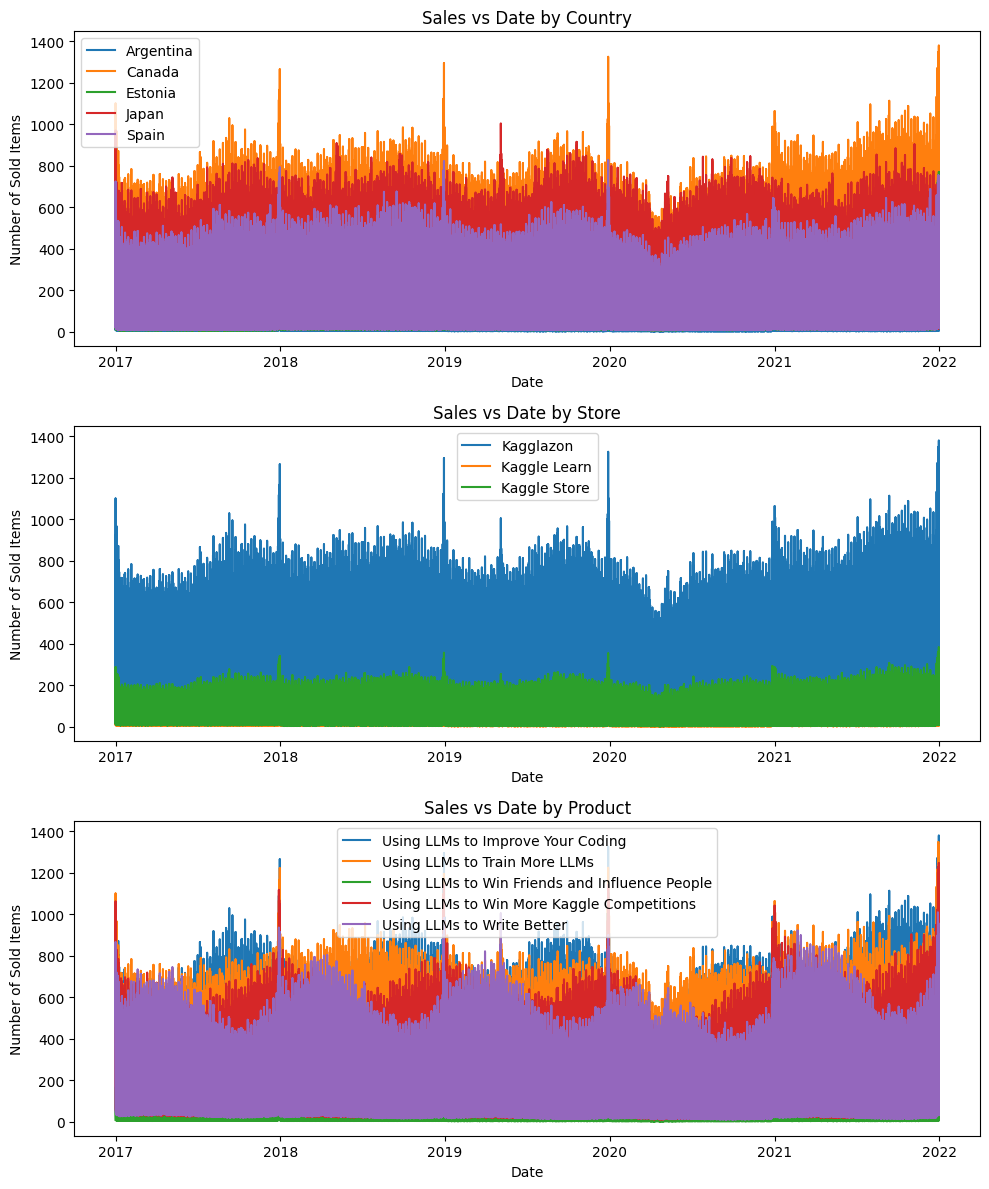

In [15]:
#create subplots with 3 rows (for country, store, product) and 1 column
fig, axes = plt.subplots(3, 1, figsize=(10, 12))
fig.subplots_adjust(hspace=0.5)

#Group the data by country, store, product .Grouping the data points (i.e. rows) based on the distinct values in the given column or columns
grouped_country = train.groupby('country')
grouped_store = train.groupby('store')
grouped_product = train.groupby('product')

#Plot for each country
for country, group in grouped_country:
    axes[0].plot(group['date'], group['num_sold'], label=country)

axes[0].set_title('Sales vs Date by Country')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Number of Sold Items')
axes[0].legend() #creates an area on the graph which describes all the elements of a graph

#Plot for each store
for store, group in grouped_store:
    axes[1].plot(group['date'], group['num_sold'], label=store)

axes[1].set_title('Sales vs Date by Store')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Number of Sold Items')
axes[1].legend()

#Plot for each product
for product, group in grouped_product:
    axes[2].plot(group['date'], group['num_sold'], label=product)

axes[2].set_title('Sales vs Date by Product')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Number of Sold Items')
axes[2].legend() #creates an area on the graph which describes all the elements of a graph.

plt.tight_layout() #automatically adjusts subplot params so that the subplot(s) fits in to the figure area
plt.show()


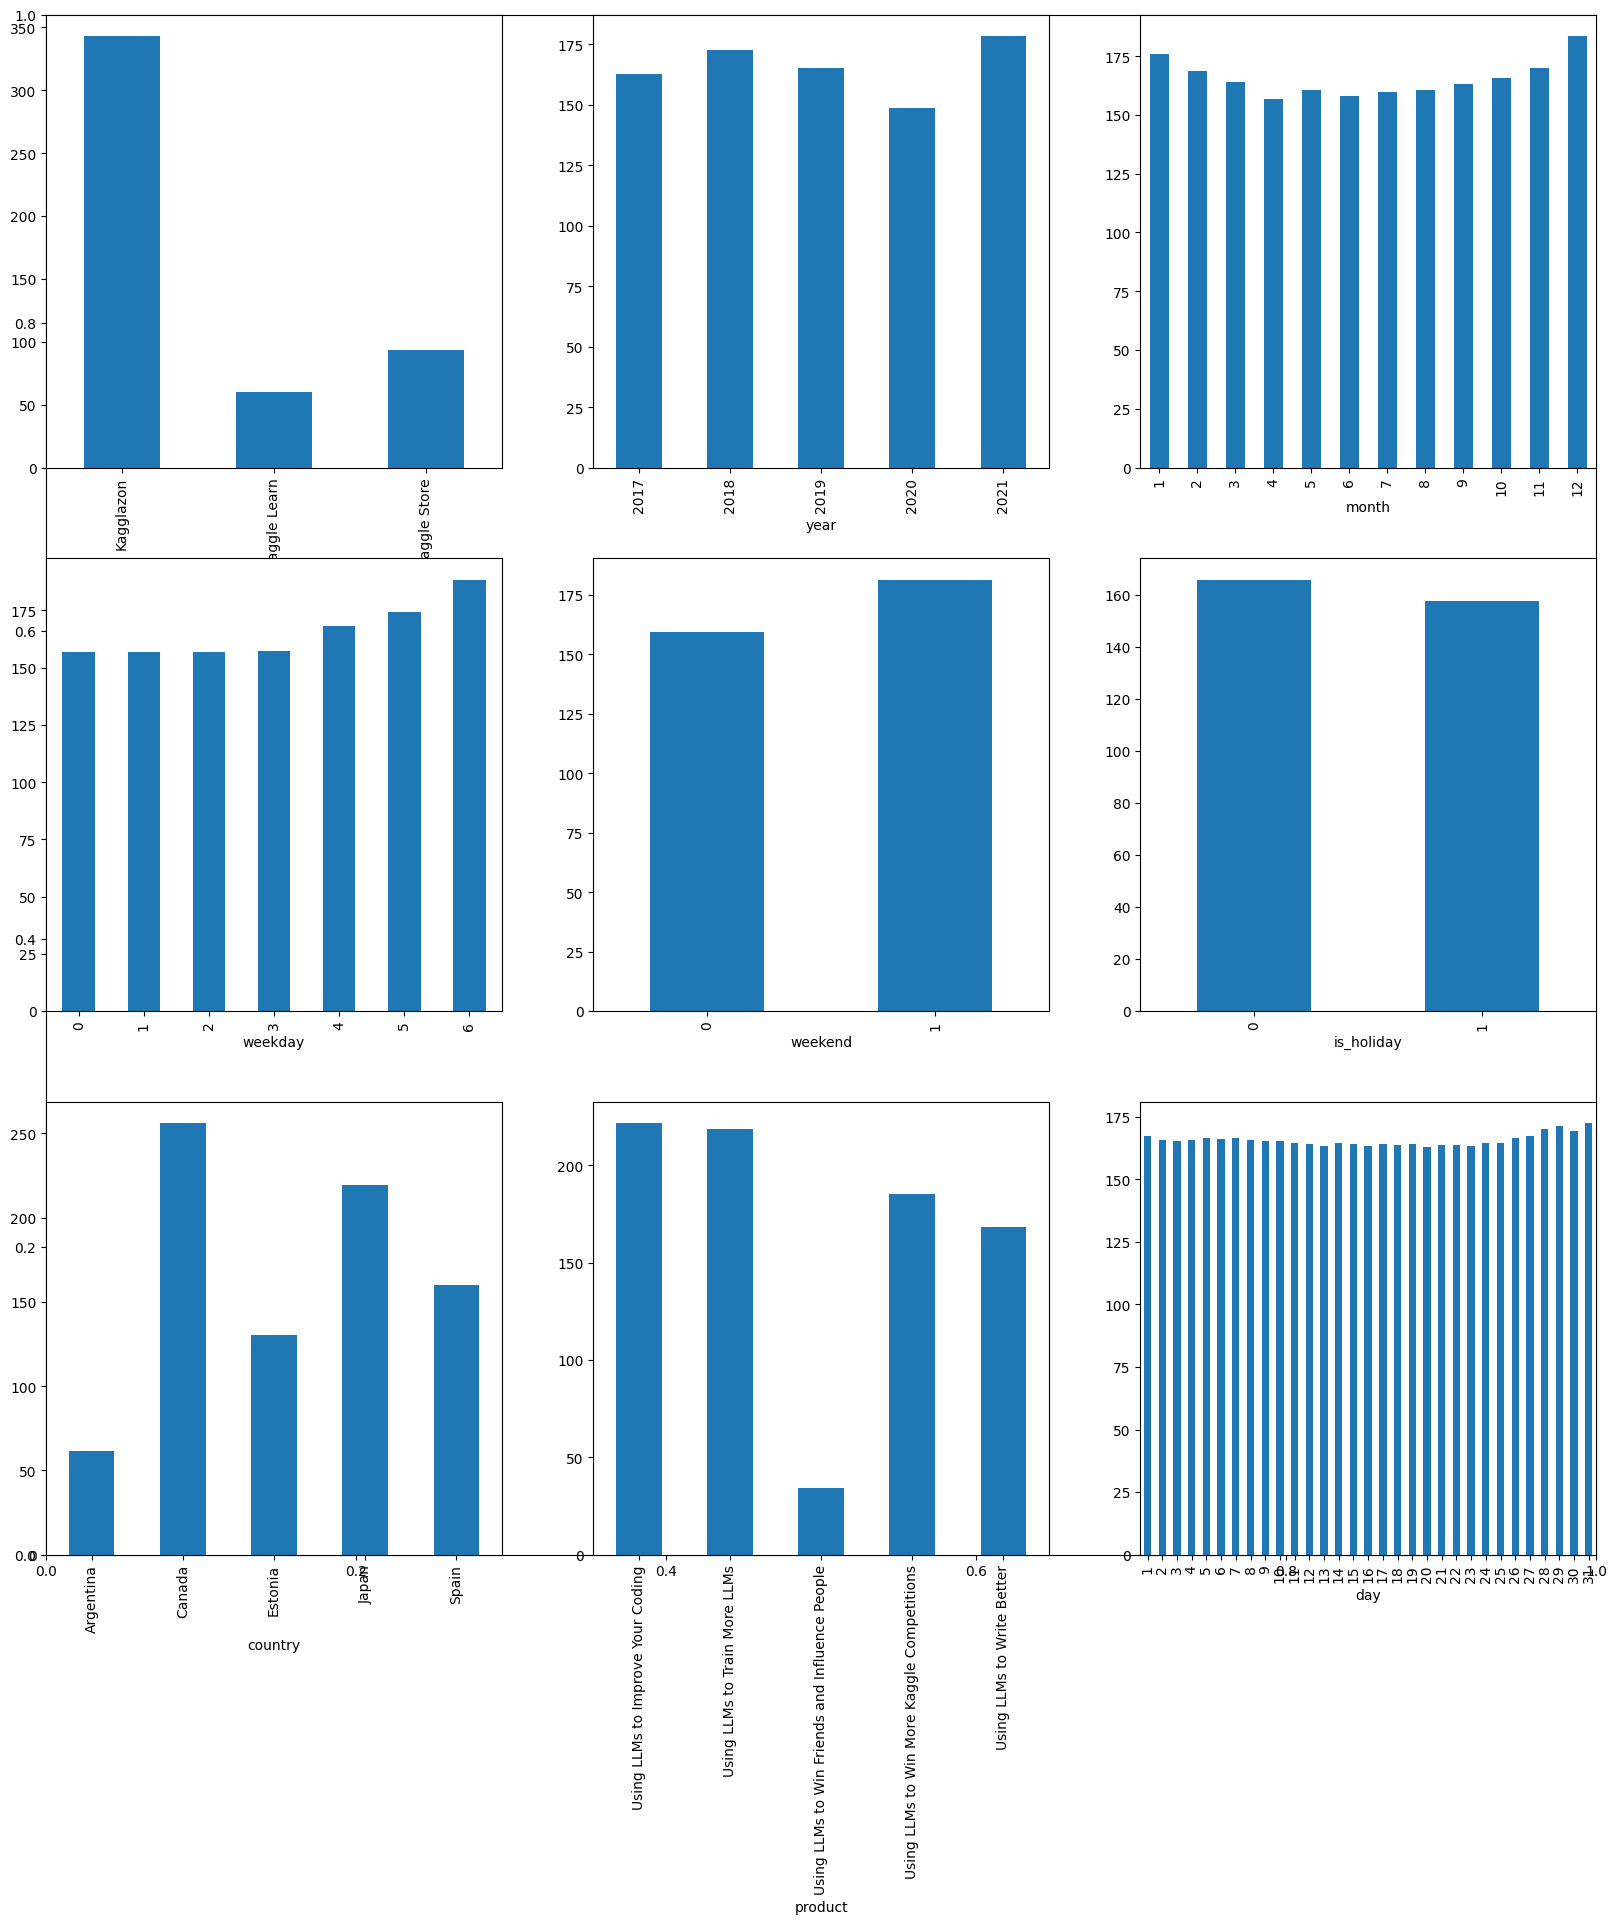

In [16]:
#Groupings for bar plots
groups = ['store', 'year', 'month', 'weekday', 'weekend', 'is_holiday', 'country',
'product', 'day']

plt.subplots(figsize=(20, 20))
for i, group in enumerate(groups):
    plt.subplot(3, 3, i + 1)
    train.groupby(group)['num_sold'].mean().plot.bar()
plt.show()

# Modelling

In [17]:
def smape(label, pred): 
    """
    Symmetrical mean absolute percentage error.
    
    Calculation that you can use to check the performance of your forecasting methods.
    wiki: https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error
    """
    return 100/len(label) * np.sum(2 * np.abs(label - pred) / (np.abs(pred) + np.abs(label)))

In [18]:
# do not need date antmore after feature engineering
train.drop(columns=["date"], inplace=True)

In [19]:
# extract labels == num_sold
y = train["num_sold"]

train.drop(columns=["num_sold"], inplace=True)

In [20]:
# understand label range
print(y.mean())

165.5226359985396


In [21]:
#handle categorial columns with one-hot-encoding before training
#removing first column to avoid dummy variable trap
train_country = pd.get_dummies(train["country"], drop_first = True)
train_store = pd.get_dummies(train["store"], drop_first = True)
train_product = pd.get_dummies(train["product"], drop_first = True)

# replace category columns with new one-hot-encoding columns
train.drop(columns=["country", "store", "product"], inplace=True)

# concat columns
X = pd.concat([train, train_country, train_store, train_product], 
              axis = 1, ignore_index = True)

In [22]:
#split  data into a training set and a testing set. random_state is used to control the randomization process when splitting a dataset into training and testing sets. Its primary purpose is to ensure the reproducibility of results by fixing the random seed for the random splitting process.
X_train, X_val, Y_train, Y_val = train_test_split(X, y,
                                                  test_size = 0.1,
                                                  random_state=42)

In [23]:
#Normalizing the features for stable and fast training
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)


In [26]:
#different ML models with diffrent levels of complexity
#
#linear regression is underfitting data
#xgboost with non-default hyperparametr choice performs better and shows no signifikant oveerfitting
#randomforest with default parametrs is overfitting but has best performance on training data
models = [
    LinearRegression(),
    XGBRegressor(),
    XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=7),  # some simple hyperparameter search
    RandomForestRegressor(),
    RandomForestRegressor(max_depth=15)  # some simple hyperparameter search
]

for model in models:
    model.fit(X_train, Y_train)

    print(f'{model} : ')

    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)

    print('Training MAE : ', mae(Y_train, train_preds))
    print('Validation MAE : ', mae(Y_val, val_preds))
#squared=False means getting a more straightforward measure of the model's performance in the same units as your target variable.
    
    print('Training RMSE : ', mse(Y_train, train_preds, squared=False)) 
    print('Training RMSE : ', mse(Y_val, val_preds, squared=False))
    
#SMAPE, which stands for Symmetric Mean Absolute Percentage Error, is a common metric used to evaluate the accuracy of forecasts or predictions in time series forecasting and regression tasks. It measures the percentage difference between predicted and actual values in a symmetric way, meaning it doesn't favor overestimation or underestimation equally.SMAPE computes the absolute percentage error for each data point (time period) by taking the absolute difference between the actual and predicted values and dividing it by the average of the absolute values of the actual and predicted values.
#When you call .values on a pandas DataFrame or Series, it returns the data stored within that DataFrame or Series as a NumPy array. This can be useful if you want to work with the data using NumPy's array functions or if you need to pass the data to a library or function that expects a NumPy array.
    print('Training SMAPE : ', smape(Y_train.values, train_preds))
    print('Validation SMAPE : ', smape(Y_val.values, val_preds))
    
    print()

LinearRegression() : 
Training MAE :  65.00574527597625
Validation MAE :  65.06504067623457
Training RMSE :  90.20633738708464
Training RMSE :  90.25908750193378
Training SMAPE :  61.193271934018696
Validation SMAPE :  60.98273941573849

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...) : 
Training MAE

As sales are on average ca. 165, having MAE at 8 seems not great, but for better results more extensive feature engieering woud be required. Random forrest comes much closer to a usable model, but only on training data, hence overfitting.

Would be interesting to see which country-store-product combination is not performing well.

In [27]:
#neural networks
#A sequential model is a linear stack of layers in a neural network. It is one of the simplest and most common types of neural network architectures. In a sequential model, each layer is connected to the one before it, and data flows sequentially through the layers from input to output
model= Sequential()

#the Input layer :
#kernel_initializer parameter is used when defining the initial values (weights) of the kernels (also known as filters or weights) in convolutional or dense layers
#input_dim is set to X_train.shape[1], which means that the number of input features for this layer is equal to the number of columns in our training data X_train

ACTIVATION = "relu"

model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1],
activation=ACTIVATION))

#the Hidden Layers:
#'normal' weight initialization
model.add(Dense(256, kernel_initializer='normal',activation=ACTIVATION))
model.add(Dense(256, kernel_initializer='normal',activation=ACTIVATION))
model.add(Dense(256, kernel_initializer='normal',activation=ACTIVATION))

#The Output Layer:
model.add(Dense(1, kernel_initializer='normal', activation='linear'))

#Compile the network :
#'Adam' is a  optimization algorithm that adapts the learning rate during training to converge faster and often performs well in practice.
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=
[RootMeanSquaredError()])
model.summary()
                

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2304      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 167,169
Trainable params: 167,169
Non-trainable params: 0
_________________________________________________________________


In [28]:
#restore_best_weightscontrols whether the callback should restore the best model weights when early stopping is triggered
early_stopping = EarlyStopping(monitor='val_loss', patience=10,
restore_best_weights=True) 

In [29]:
#batch_size determines the number of training examples that are processed in each iteration or batch during the training process.
#verbose 1: Progress bar mode (default). It prints an animated progress bar and a summary of each epoch's training progress, including loss and any specified metrics.
model.fit(X_train, Y_train, 
          validation_data=(X_val, Y_val), 
          batch_size=32,
          epochs = 150,
          verbose=1,
          callbacks=[early_stopping])

Epoch 1/150
3852/3852 [==============================] - 19s 5ms/step - loss: 17.4846 - root_mean_squared_error: 42.0162 - val_loss: 12.5788 - val_root_mean_squared_error: 26.3719
Epoch 2/150
3852/3852 [==============================] - 28s 7ms/step - loss: 12.5390 - root_mean_squared_error: 25.3258 - val_loss: 15.4647 - val_root_mean_squared_error: 29.4521
Epoch 3/150
3852/3852 [==============================] - 15s 4ms/step - loss: 11.6012 - root_mean_squared_error: 23.7366 - val_loss: 11.0642 - val_root_mean_squared_error: 22.3994
Epoch 4/150
3852/3852 [==============================] - 18s 5ms/step - loss: 11.0498 - root_mean_squared_error: 22.4907 - val_loss: 10.8000 - val_root_mean_squared_error: 22.8944
Epoch 5/150
3852/3852 [==============================] - 19s 5ms/step - loss: 10.6185 - root_mean_squared_error: 21.2801 - val_loss: 12.3867 - val_root_mean_squared_error: 24.2646
Epoch 6/150
3852/3852 [==============================] - 19s 5ms/step - loss: 10.2785 - root_mean_sq

In [30]:
train_preds = model.predict(X_train)
val_preds = model.predict(X_val)

print('Training MAE : ', mae(Y_train, train_preds))
print('Validation MAE : ', mae(Y_val, val_preds))

print('Training RMSE : ', mse(Y_train, train_preds, squared=False))
print('Validation RMSE : ', mse(Y_val, val_preds, squared=False))

print('Training SMAPE : ', smape(Y_train.values, train_preds.flatten()))
print('Validation SMAPE: ', smape(Y_val.values, val_preds.flatten()))

428/428 [==============================] - 1s 2ms/step
Training MAE :  7.63630658042324
Validation MAE :  7.953239764798162
Training RMSE :  14.209133874374842
Validation RMSE :  14.856290293658398
Training SMAPE :  4.9843970190378695
Validation SMAPE:  5.143496841948032


In [31]:
model.save(BASE_PATH / "checkpoints" / "model.keras")

The models do not significantly outrank each other in performance, we could pick either XGBoost, Randomforrest, or the NN. Here we choose the NN to predict future events, as it slightly outperforms the other models.

Note that the models are by far not optimal. For better performance we should do an extensive hyperparameter tuning and some more feature engineering.

## Predict

We first use the same preprocessing done in training and then predict the test data using the saved model.

In [24]:
loaded_model = tf.keras.models.load_model(BASE_PATH / "checkpoints" / "model.keras")

In [25]:
test = pd.read_csv(TEST_PATH, index_col="id")

#preprocessing datetime column
test["date"] = pd.to_datetime(test["date"], format="%Y-%m-%d")

#feature engineering based on dates
test["year"]= test.date.dt.year
test["month"]= test.date.dt.month
test["day"]= test.date.dt.day
test["weekday"]=test.date.dt.weekday
test["weekend"]=test.date.dt.weekday.isin([5, 6]).astype(int)
#test['time_no']=(test['date'] - dt.datetime(2017, 1, 1)) // dt.dattime(days=1)

# feature engineering add cyclical data
# test['sin'] = np.sin(np.pi * test['time_no'] / 365.0)
# test['cos'] = np.cos(np.pi * test['time_no'] / 365.0)

# feature engineering based on external holiday data
test_holidays = pd.DataFrame(columns=["date", "is_holiday"])

for country in test["country"].unique():
    country_holidays = get_holidays(country, test.date.dt.year.unique().tolist())
    country_holidays_df = pd.DataFrame({"date": country_holidays, "is_holiday": 1, "country": country})
    test_holidays = pd.concat([test_holidays, country_holidays_df])

test_holidays["date"] = pd.to_datetime(test_holidays["date"], format="%Y-%m-%d")

test = test.merge(test_holidays, on=["date", "country"], how="left").fillna({"is_holiday": 0})

# feature engineering based on external gdp data
print("Start fetching gdp data...")
gdp_tmp = copy.deepcopy(gdp_all)  # same rel scale for gdp
gdp_all = []
# loop over unique countries
for country in tqdm(test.country.unique()):
    gdp_country = []
    # loop over years
    for year in test.date.dt.year.unique().tolist():
        # download gdp data
        gdp_data = get_gdp_per_capita(country, year)
        gdp_country.append(gdp_data)
    gdp_all.append(gdp_country)
print("...Fetched gdp data")

gdp_all = np.array(gdp_all)
rel_gdp = gdp_all / gdp_tmp.sum()

rel_gdp_df = pd.DataFrame(rel_gdp, index=test.country.unique(), columns=[2022])

test['rel_gdp'] = test.apply(lambda row: rel_gdp_df.loc[row.country, row.date.year], axis=1)

# preprocessing for modelling
test.drop(columns=["date"], inplace=True)

test_country = pd.get_dummies(test["country"], drop_first = True)
test_store = pd.get_dummies(test["store"], drop_first = True)
test_product = pd.get_dummies(test["product"], drop_first = True)

test.drop(columns=["country", "store", "product"], inplace=True)

X_test = pd.concat([test, test_country, test_store, test_product], 
              axis = 1, ignore_index = True)

X_test = scaler.transform(X_test)




Start fetching gdp data...


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


...Fetched gdp data


In [26]:
test_pred = loaded_model.predict(X_test)


856/856 [==============================] - 2s 2ms/step


In [27]:
train_new = pd.read_csv(TRAIN_PATH)
test_new = pd.read_csv(TEST_PATH)

test_new["num_sold"] = test_pred.flatten()

df = pd.concat([train_new, test_new])

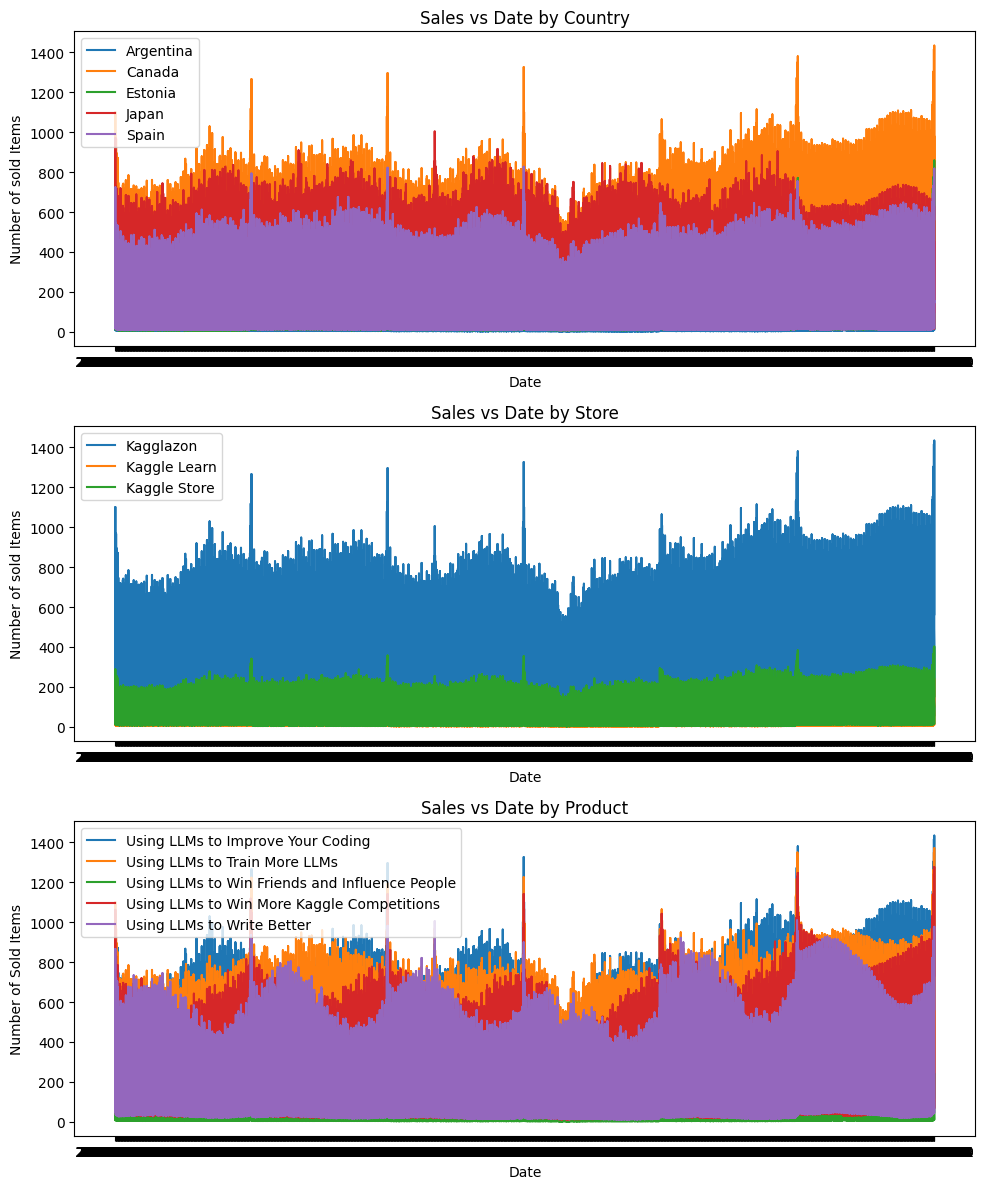

In [28]:
#Create subplots with 3 rows (for country, store, product) and 1 column
fig, axes = plt.subplots(3, 1, figsize=(10,12))
fig.subplots_adjust(hspace=0.5)

#Group data by country, store, product
grouped_country = df.groupby('country')
grouped_store = df.groupby('store')
grouped_product = df.groupby('product')

#Plot for each country
for country, group in grouped_country:
    axes[0].plot(group.date, group['num_sold'], label=country)

axes[0].set_title('Sales vs Date by Country')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Number of sold Items')
axes[0].legend() #legend is an area describing the elements of the graph.

#Plot for each store
for store, group in grouped_store:
    axes[1].plot(group.date, group['num_sold'], label=store)

axes[1].set_title('Sales vs Date by Store')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Number of sold Items')
axes[1].legend()

#Plot for each product
for product, group in grouped_product:
    axes[2].plot(group.date, group['num_sold'], label=product)

axes[2].set_title('Sales vs Date by Product')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Number of Sold Items')
axes[2].legend()

plt.tight_layout()
plt.show()

In [29]:
df["num_sold"] = df["num_sold"].apply(lambda num: int(num))

In [31]:
df.to_csv(DATA_PATH / "prediction.csv", index=False)